<a href="https://colab.research.google.com/github/faizankshaikh/AV_Article_Codes/blob/master/Case_study_preferred_tools_ICLR2020/original_code/Case_study_preferred_tools_ICLR2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install openreview-py
!pip install pipreqs

In [0]:
%matplotlib inline

import os
import re
import sys
import requests
import openreview
import pandas as pd
import matplotlib.pyplot as plt

from random import choice
from wordcloud import WordCloud
from urllib.parse import urlparse

In [2]:
client = openreview.Client(baseurl="https://openreview.net")

blind_notes = {
    note.id: note
    for note in openreview.tools.iterget_notes(
        client,
        invitation="ICLR.cc/2020/Conference/-/Blind_Submission",
        details="original",
    )
}

all_decision_notes = openreview.tools.iterget_notes(
    client, invitation="ICLR.cc/2020/Conference/Paper.*/-/Decision"
)

accepted_submissions = [
    blind_notes[decision_note.forum]
    for decision_note in all_decision_notes
    if "Accept" in decision_note.content["decision"]
]

len(accepted_submissions)

687

In [0]:
code_present = 0
code_links = []
for note in accepted_submissions:
    try:
        code_links.append(note.content["code"])
        # print("code found")
        code_present += 1
    except:
        print("Unexpected error:", sys.exc_info()[0])

In [4]:
code_present

344

In [5]:
urlparse(choice(code_links))

ParseResult(scheme='https', netloc='drive.google.com', path='/drive/folders/1kIOc4SlAJllUJsrr2OnZ4izIQIw2JexU', params='', query='usp=sharing', fragment='')

In [0]:
code_links_df = pd.DataFrame({"links": code_links})

In [0]:
code_links_df["domains"] = code_links_df.links.apply(lambda x: urlparse(x)[1])

In [8]:
code_links_df.domains.value_counts()

github.com                       268
drive.google.com                  28
www.dropbox.com                    9
anonymous.4open.science            8
bit.ly                             5
storage.googleapis.com             3
s000.tinyupload.com                2
sites.google.com                   2
docs.google.com                    1
nikaashpuri.github.io              1
nitishgupta.github.io              1
clevrer.csail.mit.edu              1
wgrathwohl.github.io               1
dap.csail.mit.edu                  1
www.robots.ox.ac.uk                1
www.daml.in.tum.de                 1
automated-discovery.github.io      1
rohitgirdhar.github.io             1
danijar.com                        1
www.github.com                     1
anonfile.com                       1
goo.gl                             1
toiaydcdyywlhzvlob.github.io       1
whyu.me                            1
www.sendspace.com                  1
mega.nz                            1
www.cs.cmu.edu                     1
N

In [0]:
temp_link = ""


def clean_github_link(link):
    link = link.strip()
    if not link[-4:] == ".git":
        return link + ".git"
    else:
        return link


github_repo_links = (
    code_links_df.loc[code_links_df.domains == "github.com"]
    .links.apply(clean_github_link)
    .values
)

In [10]:
# takes about 24 minutes to download
for link in github_repo_links:
    !git clone $link --depth 1 --quiet

fatal: repository 'https://github.com/tensorflow/addons/blob/master/tensorflow_addons/optimizers/lamb.py.git/' not found
fatal: repository 'https://github.com/carloderamo/shared/tree/master.git/' not found
Cloning into 'proxsgd'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 59 (delta 19), reused 33 (delta 12), pack-reused 0
Unpacking objects: 100% (59/59), done.
/bin/bash: https://github.com/cc-hpc-itwm/proxsgd.git: No such file or directory
fatal: repository 'https://github.com/suraj-nair-1/google-research/tree/master/hierarchical_foresight.git/' not found
fatal: repository 'https://github.com/google-research/google-research/tree/master/cfq.git/' not found
remote: Not Found
fatal: repository 'https://github.com/hangg7/deformable-kernels/.git/' not found
fatal: repository 'https://github.com/google-research/google-research/tree/master/meta_learning_without_memorization.git/' not fou

In [11]:
code_links_df.loc[code_links_df.domains == "github.com"].links.apply(
    lambda x: urlparse(x)[2].split("/")[1]
).value_counts().head(10)

google-research     10
facebookresearch     4
TAMU-VITA            3
TonghanWang          2
JHL-HUST             2
automl               2
epfml                2
eth-sri              2
haebeom-lee          2
tensorflow           2
Name: links, dtype: int64

In [0]:
root = "."
dirlist = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
print(dirlist)

In [0]:
dirlist.remove('.config')
dirlist.remove('sample_data')

In [14]:
len(dirlist)

247

In [0]:
# takes about 10 minutes to run
for repo in dirlist:
    path = "/content/" + repo
    if os.path.exists(path + "/requirements.txt"):
        pass
    else:
        !pipreqs $path

In [0]:
has_req_cnt = no_req_cnt = 0
for repo in dirlist:
    path = "/content/" + repo
    if os.path.exists(path + "/requirements.txt"):
        has_req_cnt += 1
    else:
        no_req_cnt += 1

In [17]:
has_req_cnt, no_req_cnt

(237, 10)

In [18]:
all_repo_names = []
all_tool_names = []
for repo in dirlist:
    try:
        repo_name = repo
        with open("/content/" + repo + "/" + "requirements.txt", "r") as f:
            tools = f.readlines()
        tool_names = ",".join(tools).lower()

        all_repo_names.append(repo_name)
        all_tool_names.append(tool_names)
    except:
        print("Unexpected error for ", repo, sys.exc_info()[0])

Unexpected error for  SI-NI-FGSM <class 'FileNotFoundError'>
Unexpected error for  space2vec <class 'FileNotFoundError'>
Unexpected error for  synthfeedback <class 'FileNotFoundError'>
Unexpected error for  QCNN <class 'FileNotFoundError'>
Unexpected error for  GraN-DAG <class 'FileNotFoundError'>
Unexpected error for  GLISTA <class 'FileNotFoundError'>
Unexpected error for  ACMC_ICLR <class 'FileNotFoundError'>
Unexpected error for  PCMC-Net <class 'FileNotFoundError'>
Unexpected error for  pcl2pcl-gan-pub <class 'FileNotFoundError'>
Unexpected error for  NAS-Benchmark <class 'FileNotFoundError'>


In [19]:
all_tools = pd.DataFrame(
    {"all_repo_names": all_repo_names, "all_tool_names": all_tool_names}
)
all_tools.head()

,all_repo_names,all_tool_names
0,KP2D,\n
1,CN-DPM,"ipdb\n,jupyterlab\n,matplotlib\n,numpy\n,pyyam..."
2,GLAD,"numpy==1.18.3\n,pandas==1.0.3\n,matplotlib==3...."
3,bert_score,"# pytorch\n,torch>=1.0.0\n,# progress bars in ..."
4,delay_stability,"torchvision==0.6.0+cu101\n,bokeh==1.4.0\n,six=..."


In [0]:
all_tools.to_csv("all_tools.csv", index=False)

In [0]:
all_tools = pd.read_csv("all_tools.csv")

In [23]:
all_tools.head()

,all_repo_names,all_tool_names
0,KP2D,\n
1,CN-DPM,"ipdb\n,jupyterlab\n,matplotlib\n,numpy\n,pyyam..."
2,GLAD,"numpy==1.18.3\n,pandas==1.0.3\n,matplotlib==3...."
3,bert_score,"# pytorch\n,torch>=1.0.0\n,# progress bars in ..."
4,delay_stability,"torchvision==0.6.0+cu101\n,bokeh==1.4.0\n,six=..."


In [24]:
all_tools.shape

(237, 2)

In [0]:
def cleaner(tool_list):
    cleaned_list = ""
    try:
        cleaned_list = []
        for tool in tool_list:
            cleaned_tool = re.findall("^\w+", tool)
            if not cleaned_tool:
                pass
            else:
                cleaned_list.append(cleaned_tool[0])
        cleaned_list = ",".join(cleaned_list)
        return cleaned_list
    except:
        tool_list = ",".join(tool_list)
        "unclean_list".join(tool_list)
        return tool_list


all_tools["all_tool_names_cleaned"] = all_tools.all_tool_names.str.split(",").apply(
    cleaner
)

In [26]:
all_tools.head()

,all_repo_names,all_tool_names,all_tool_names_cleaned
0,KP2D,\n,
1,CN-DPM,"ipdb\n,jupyterlab\n,matplotlib\n,numpy\n,pyyam...","ipdb,jupyterlab,matplotlib,numpy,pyyaml,tensor..."
2,GLAD,"numpy==1.18.3\n,pandas==1.0.3\n,matplotlib==3....","numpy,pandas,matplotlib,scipy,torch,networkx,s..."
3,bert_score,"# pytorch\n,torch>=1.0.0\n,# progress bars in ...","torch,tqdm,transformers,matplotlib,pandas,numpy"
4,delay_stability,"torchvision==0.6.0+cu101\n,bokeh==1.4.0\n,six=...","torchvision,bokeh,six,torch,numpy,scipy,pandas..."


In [27]:
all_tools.all_tool_names_cleaned.str.contains("torch").sum()

154

In [0]:
def give_score(tool_name, offset=0):
    num = all_tools.all_tool_names_cleaned.str.contains(tool_name).sum()
    num += offset
    print(
        "Count of {} is {} and total usage is {}%".format(
            tool_name, num, round((num / all_tools.shape[0]) * 100, 4)
        )
    )

In [29]:
give_score("torch")
print()
give_score("tensorflow", offset=12)
print()
give_score("keras")

Count of torch is 154 and total usage is 64.9789%

Count of tensorflow is 95 and total usage is 40.0844%

Count of keras is 23 and total usage is 9.7046%


In [30]:
give_score("transformers")

Count of transformers is 8 and total usage is 3.3755%


In [31]:
give_score("tensorboard")

Count of tensorboard is 56 and total usage is 23.6287%


In [32]:
give_score("gym")

Count of gym is 24 and total usage is 10.1266%


In [33]:
give_score("networkx")

Count of networkx is 25 and total usage is 10.5485%


In [34]:
all_tools.all_tool_names_cleaned.str.split(",", expand=True).stack().unique().shape

(687,)

In [35]:
all_tools.all_tool_names_cleaned.str.split(",", expand=True).stack().value_counts()[:50]

numpy            206
torch            156
matplotlib       114
scipy            110
tensorflow        92
tqdm              89
torchvision       86
pillow            70
pandas            65
scikit_learn      48
keras             39
tensorboardx      39
scikit            31
seaborn           30
pyyaml            28
six               27
h5py              27
requests          27
tensorboard       25
gym               25
networkx          25
python            23
absl              23
pytest            22
imageio           20
protobuf          19
opencv_python     19
ipython           18
jupyter           15
nltk              14
joblib            14
mkl               14
opencv            13
certifi           13
                  13
urllib3           13
pyparsing         13
cloudpickle       12
termcolor         12
click             12
cycler            12
mock              12
kiwisolver        11
chardet           11
xorg              11
idna              11
pytz              11
future       

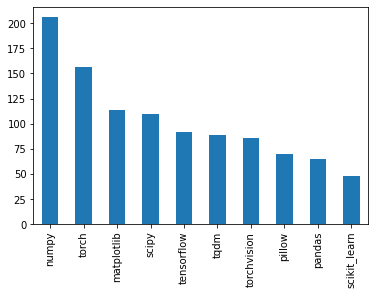

In [36]:
all_tools.all_tool_names_cleaned.str.split(",", expand=True).stack().value_counts()[
    :10
].plot(kind="bar")

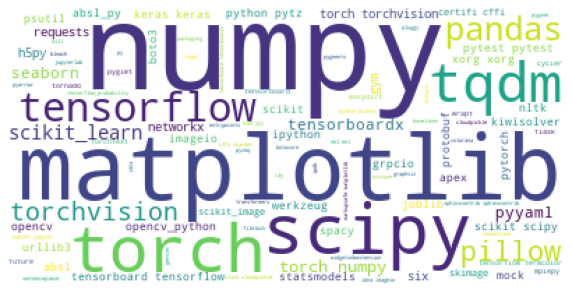

In [37]:
all_tool_string = ",".join(all_tools.all_tool_names_cleaned)

wordcloud = WordCloud(background_color="white", max_words=100)
wordcloud.generate(all_tool_string)

plt.figure(figsize=(10, 20))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()